In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask
import dask.dataframe as ddf
import numpy as np
from tqdm import tqdm
import pickle
import gc

In [2]:
!hostname

qa-a100-001.crc.nd.edu


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
import sys
sys.version

'3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]'

In [5]:
with open('/scratch365/cmoore24/data/signal_vars.pkl', 'rb') as f:
    signal = pickle.load(f)

In [6]:
gc.collect()
with open('/scratch365/cmoore24/data/combed_qcd.pkl', 'rb') as f:
    background = pickle.load(f)

OSError: [Errno 14] Bad address

In [1]:
hgg = signal['hgg']
hbb = signal['hbb']
del(signal)

NameError: name 'signal' is not defined

In [10]:
hgg

,FatJets.area,FatJets.eta,FatJets.mass,FatJets.msoftdrop,FatJets.n2b1,FatJets.n3b1,FatJets.phi,FatJets.pt,FatJets.nConstituents,FatJets.color_ring,FatJets.d2b1,FatJets.u1,FatJets.u2,FatJets.u3,FatJets.d3,FatJets.m2,FatJets.m3,FatJets.n4
0,1.974609,0.993042,82.43750,82.062500,0.383301,1.863281,-1.008545,300.000,62,1.382130,2.019578,0.139023,0.015476,0.001656,1.346227,0.111321,0.106993,9.637352
1,2.013672,0.810913,48.78125,46.093750,0.198486,-1.000000,2.266113,265.000,25,1.010107,0.957660,0.087691,0.004739,0.000209,2.325230,0.054043,0.044160,19.379188
2,2.044922,0.122391,99.18750,96.375000,0.358398,-1.000000,3.134277,253.750,71,0.500589,1.257573,0.221576,0.031075,0.004244,1.315194,0.140247,0.136581,6.150316
3,2.054688,-0.869507,64.87500,30.390625,0.431641,1.671875,1.935547,337.500,59,1.097020,2.245250,0.052005,0.007008,0.000901,1.332486,0.134759,0.128602,7.463764
4,2.074219,-1.751465,68.31250,4.429688,0.336670,-1.000000,-0.906250,319.500,29,1.123684,1.577748,0.010093,0.001174,0.000094,0.840861,0.116329,0.079665,6.904022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,2.013672,1.105713,60.43750,40.093750,0.336182,1.431641,2.816406,345.250,56,1.026974,1.315994,0.073293,0.009653,0.001270,1.463774,0.131700,0.131518,6.407066
2765,1.955078,0.656250,81.68750,54.031250,0.300537,1.576172,2.278320,462.250,58,1.012454,1.193669,0.070175,0.007114,0.000780,1.449449,0.101370,0.109586,8.036519
2766,2.154297,0.008310,101.56250,101.125000,0.371338,1.683594,-1.207031,293.000,63,1.111015,1.856582,0.178357,0.020641,0.002473,1.139389,0.115729,0.119833,7.693052
2767,2.224609,-0.882202,112.87500,110.562500,0.302490,1.509766,2.037598,296.500,62,49.112613,1.147010,0.210949,0.022830,0.002647,1.537888,0.108224,0.115942,7.052629


In [310]:
var_keys = list(hgg.keys())

In [11]:
import xgboost

In [311]:
items = [
#     'FatJets.area', 
#     'FatJets.eta', 
#     'FatJets.mass',
#     'FatJets.msoftdrop', 
#     'FatJets.n2b1', 
#     'FatJets.n3b1', 
#     'FatJets.phi', 
#     'FatJets.pt',
#     'FatJets.u1',
    'FatJets.m2',
    'isSignal'
]

In [312]:
hgg['isSignal'] = np.ones_like(hgg[items[0]])

In [313]:
background['isSignal'] = np.zeros_like(background[items[0]])

In [314]:
sizes = []
for i in background:
    sizes.append(len(background[i]))

losses = [(x - min(sizes)) for x in sizes]
for i in background:
    background[i] = background[i][:min(sizes)]

In [315]:
background = pd.DataFrame.from_dict(background)

In [316]:
small_sig = hgg[items]
small_bkg = background[items]
#del(background)
gc.collect()

0

In [317]:
NDIM = len(items) - 1
df_all = pd.concat([small_sig, small_bkg])
dataset = df_all.values
X = dataset[:, 0:NDIM]
y = dataset[:, NDIM]

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [319]:
X_train

array([[-0.36221379],
       [-0.73195178],
       [ 1.23207712],
       ...,
       [-0.83630975],
       [ 0.37041   ],
       [ 0.7579753 ]])

In [320]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [321]:
# Build our model.
gc.collect()
torch.cuda.empty_cache()

class NeuralNetwork(nn.Module):
    def __init__(self, width=2):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

model= nn.DataParallel(model,device_ids = [0, 1, 2, 3])
model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
X_train.shape[0]

NameError: name 'X_train' is not defined

In [322]:
losses, test_losses = [], []
min_loss, stale_epochs = 100.0, 0

batch_size = 2097152
for t in tqdm(range(2)):
    batch_loss, batch_test_loss = [], []
    
    for b in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[b : b + batch_size]
        y_batch = y_train[b : b + batch_size]
        model.train()
        y_pred = model(X_batch)
        print(f"pred: {y_pred}")
        y_b = y_batch.view(-1,1)
        print(f"y_b: {y_b}")

        # Compute and print loss.
        loss = loss_fn(y_pred, y_b)
        print(f"loss: {loss.item()}")
        batch_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.inference_mode():

            model.eval()
            test_pred = model(X_test)

            test_label = y_test.view_as(test_pred)
            test_loss = loss_fn(test_pred, test_label)
            batch_test_loss.append(test_loss.item())

             
            # Monitor the loss function to prevent overtraining.
#             if stale_epochs > 20:
#                 break

#             if test_loss.item() - min_loss < 0:
#                 min_loss = test_loss.item()
#                 stale_epochs = 0
#                 torch.save(model.state_dict(), "pytorch_model_best.pth")
#             else:
#                 stale_epochs += 1
    
    losses.append(np.mean(batch_loss))
    test_losses.append(np.mean(batch_test_loss))

  0%|          | 0/2 [00:00<?, ?it/s]

pred: tensor([[-0.6090],
        [-0.6090],
        [-0.6090],
        ...,
        [-0.6090],
        [-0.6090],
        [-0.6090]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', 

 50%|█████     | 1/2 [00:00<00:00,  3.65it/s]

pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>

100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>)
y_b: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')
loss: nan
pred: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<GatherBackward>

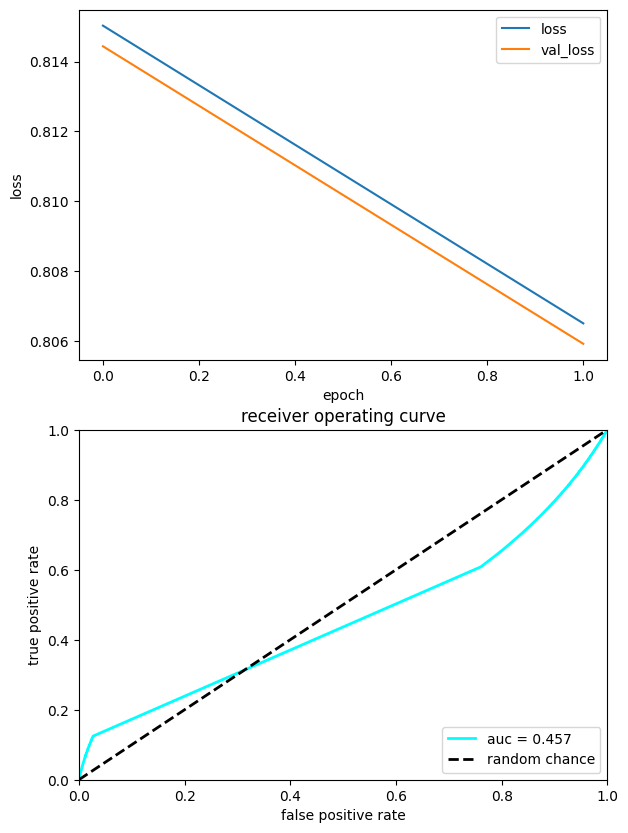

In [286]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses, label="loss")
    ax.plot(test_losses, label="val_loss")
    ax.legend(loc="upper right")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_title("receiver operating curve")
    ax.legend(loc="lower right")
    plt.show()

In [133]:
model.state_dict()

OrderedDict([('module.linear_relu_stack.0.weight',
              tensor([[ 0.1147,  0.5910,  0.1579,  ..., -0.1759,  0.1534,  0.0067],
                      [ 0.2177, -0.0351,  0.1580,  ..., -0.1993, -0.1835,  0.0123],
                      [ 0.1148, -0.0053,  0.2973,  ..., -0.1418,  0.0696, -0.2141],
                      ...,
                      [ 0.3320,  0.0870,  0.5298,  ...,  0.0779,  0.0274, -0.3909],
                      [-0.0853,  0.2816, -0.1269,  ...,  0.4472, -0.2233, -0.2632],
                      [ 0.1649, -0.3800,  0.2422,  ...,  0.3389, -0.0071, -0.2146]],
                     device='cuda:0')),
             ('module.linear_relu_stack.0.bias',
              tensor([-3.8991e-01, -1.5082e-01, -1.8591e-01,  1.0593e-02,  4.8519e-01,
                      -4.5546e-01, -3.0606e-01,  8.6872e-02,  2.3770e-01,  7.0281e-02,
                      -1.6179e-01,  3.4154e-01,  4.0441e-01, -2.6660e-01, -2.5774e-01,
                       2.9825e-01,  2.7618e-01,  1.4320e-01, -8.443

In [242]:
losses

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [244]:
small_sig

,FatJets.color_ring,isSignal
0,1.382130,1.0
1,1.010107,1.0
2,0.500589,1.0
3,1.097020,1.0
4,1.123684,1.0
...,...,...
2764,1.026974,1.0
2765,1.012454,1.0
2766,1.111015,1.0
2767,49.112613,1.0
